# Wineデータの読み込み

In [1]:
import pandas as pd

df_wine = pd.read_csv('https://archive.ics.uci.edu/ml/'
                      'machine-learning-databases/wine/wine.data',
                      header=None)

# 1. 標準化

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

X, y = df_wine.iloc[:, 1:].values, df_wine.iloc[:, 0].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=0)

sc = StandardScaler() # 平均と標準偏差を用いて標準化
X_train_std = sc.fit_transform(X_train)
X_test_std = sc.transform(X_test)

# 2. 共分散行列の作成
# 3. 共分散行列から固有値ベクトルと固有値に分解

In [3]:
import numpy as np
cov_mat = np.cov(X_train_std.T) # 共分散行列を作成
eigen_vals, eigen_vecs = np.linalg.eig(cov_mat) # 固有値と固有ベクトルを計算
print('\nEigenvalues \n%s' % eigen_vals)


Eigenvalues 
[4.84274532 2.41602459 1.54845825 0.96120438 0.84166161 0.6620634
 0.51828472 0.34650377 0.3131368  0.10754642 0.21357215 0.15362835
 0.1808613 ]


# 4. 固有値を降順でソートして,固有ベクトルをランク付

固有値$ \lambda_j $の分散説明率
$$
\frac{\lambda_j}{\sum_{j=1}^{d} \lambda_j}
$$

In [4]:
tot = sum(eigen_vals) # 固有値を合計
var_exp = [(i / tot) for i in sorted(eigen_vals, reverse=True)] # 分散説明率を計算し,降順にソート
cum_var_exp = np.cumsum(var_exp) # 分散説明率の累積和を取得

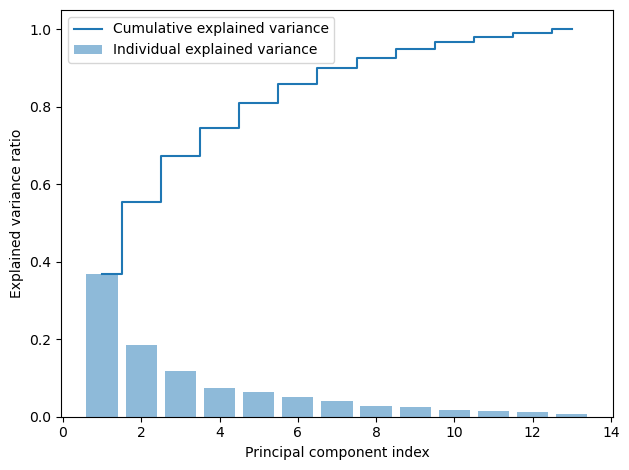

In [5]:
import matplotlib.pyplot as plt

plt.bar(range(1, 14), var_exp, alpha=0.5, align='center',
        label='Individual explained variance')
plt.step(range(1, 14), cum_var_exp, where='mid',
         label='Cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal component index')
plt.legend(loc='best')
plt.tight_layout()

plt.show()

# 5. 固有値の大きいものから順に固有対を並べ替え

In [6]:
eigen_pairs = [(np.abs(eigen_vals[i]), eigen_vecs[:,i]) for i in range(len(eigen_vals))] # {固有値,固有ベクトル}
eigen_pairs.sort(key=lambda k: k[0], reverse=True) # 大きい順に並べ替え

# 6. 上位２つの固有ベクトルから射影行列Wの作成

In [7]:
w = np.hstack((eigen_pairs[0][1][:, np.newaxis], eigen_pairs[1][1][:, np.newaxis]))
print('Matrix W:\n', w)

Matrix W:
 [[-0.13724218  0.50303478]
 [ 0.24724326  0.16487119]
 [-0.02545159  0.24456476]
 [ 0.20694508 -0.11352904]
 [-0.15436582  0.28974518]
 [-0.39376952  0.05080104]
 [-0.41735106 -0.02287338]
 [ 0.30572896  0.09048885]
 [-0.30668347  0.00835233]
 [ 0.07554066  0.54977581]
 [-0.32613263 -0.20716433]
 [-0.36861022 -0.24902536]
 [-0.29669651  0.38022942]]


# 7. W(13×2)から入力データセットX(124×13)を変換(X→X')  
(124×13)(13×2) →(124×2)

In [8]:
X_train_std[0].dot(w) # x' = xW

array([2.38299011, 0.45458499])

In [9]:
X_train_pca = X_train_std.dot(w) # X' = XW

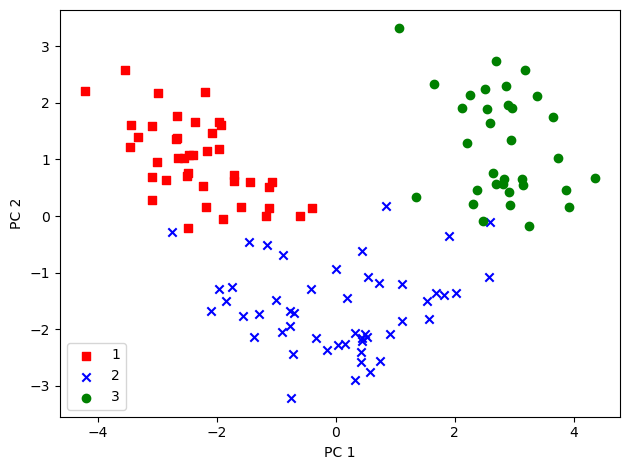

In [10]:
colors = ['r', 'b', 'g']
markers = ['s', 'x', 'o']

for l, c, m in zip(np.unique(y_train), colors, markers):
    plt.scatter(X_train_pca[y_train == l, 0], 
                X_train_pca[y_train == l, 1], 
                c=c, label=l, marker=m)

plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.legend(loc='lower left')
plt.tight_layout()
plt.show()

PC1の方がPC2よりも分散が大きいので（降順にソートしてるから数字が若い方が大きい）横軸方向によく広がっている

# 決定境界描画する関数の定義

In [11]:
from matplotlib.colors import ListedColormap

def plot_decision_regions(X, y, classifier, resolution=0.02):

    # setup marker generator and color map
    markers = ('s', 'x', 'o', '^', 'v')
    colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
    cmap = ListedColormap(colors[:len(np.unique(y))])

    # plot the decision surface
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                           np.arange(x2_min, x2_max, resolution))
    Z = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    Z = Z.reshape(xx1.shape)
    plt.contourf(xx1, xx2, Z, alpha=0.4, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())

    # plot examples by class
    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x=X[y == cl, 0], 
                    y=X[y == cl, 1],
                    alpha=0.6, 
                    color=cmap(idx),
                    edgecolor='black',
                    marker=markers[idx], 
                    label=cl)

# ロジスティック回帰を用いて,PCAで次元削減したデータセットを分類

In [12]:
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA

pca = PCA(n_components=2) # 主成分分析
lr = LogisticRegression(multi_class='ovr', random_state=1, solver='lbfgs') # ロジスティック回帰

# 次元削減
X_train_pca = pca.fit_transform(X_train_std)
X_test_pca = pca.transform(X_test_std)

lr.fit(X_train_pca, y_train) # 削減したデータセットでロジスティック回帰モデルを適合

LogisticRegression(multi_class='ovr', random_state=1)

/var/folders/9z/vmk05b5s1mlcffm1x6y0_p8w0000gn/T/ipykernel_95152/49398212.py:23: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(x=X[y == cl, 0],


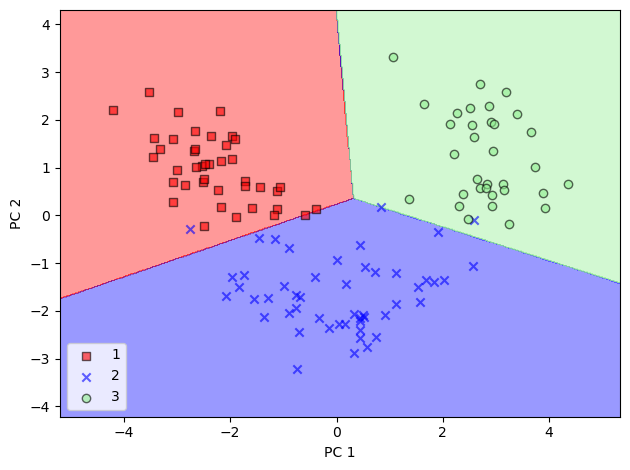

In [13]:
plot_decision_regions(X_train_pca, y_train, classifier=lr)
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.legend(loc='lower left')
plt.tight_layout()
plt.show()

/var/folders/9z/vmk05b5s1mlcffm1x6y0_p8w0000gn/T/ipykernel_95152/49398212.py:23: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(x=X[y == cl, 0],


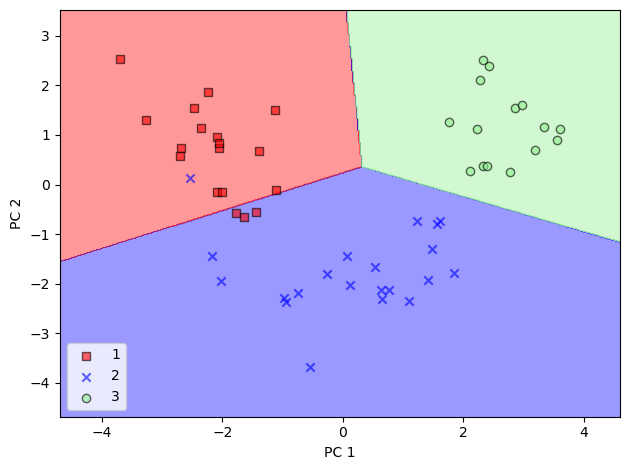

In [14]:
plot_decision_regions(X_test_pca, y_test, classifier=lr)
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.legend(loc='lower left')
plt.tight_layout()
plt.show()

In [15]:
pca = PCA(n_components=None)
X_train_pca = pca.fit_transform(X_train_std)

pca.explained_variance_ratio_

array([0.36951469, 0.18434927, 0.11815159, 0.07334252, 0.06422108,
       0.05051724, 0.03954654, 0.02643918, 0.02389319, 0.01629614,
       0.01380021, 0.01172226, 0.00820609])

# LDA

# 1. d次元のデータセットを標準化(済)
# 2. クラスごとに平均ベクトルを計算

In [16]:
np.set_printoptions(precision=4)
mean_vecs = []
for label in range(1, 4):
    mean_vecs.append(np.mean(X_train_std[y_train==label], axis=0))
    print('MV %s: %s\n' % (label, mean_vecs[label-1]))

MV 1: [ 0.9066 -0.3497  0.3201 -0.7189  0.5056  0.8807  0.9589 -0.5516  0.5416
  0.2338  0.5897  0.6563  1.2075]

MV 2: [-0.8749 -0.2848 -0.3735  0.3157 -0.3848 -0.0433  0.0635 -0.0946  0.0703
 -0.8286  0.3144  0.3608 -0.7253]

MV 3: [ 0.1992  0.866   0.1682  0.4148 -0.0451 -1.0286 -1.2876  0.8287 -0.7795
  0.9649 -1.209  -1.3622 -0.4013]



# 3. クラス内変動行列の計算
$$
\boldsymbol{S_W} = \sum_{i=1}^{c} \boldsymbol{S_i} \\
\boldsymbol{S_i} = \sum_{\boldsymbol{x}\in D_i}(\boldsymbol{x}-m_i)(\boldsymbol{x}-m_i)^T
$$ 

In [17]:
d = 13 #特徴量の個数
S_W = np.zeros((d, d))
for label, mv in zip(range(1,4), mean_vecs):
    class_scatter = np.zeros((d,d))
    for row in X_train_std[y_train == label]:
        row, mv = row.reshape(d,1), mv.reshape(d, 1) # 列ベクトルに
        class_scatter += (row - mv).dot((row - mv).T)
    S_W += class_scatter

print('Within-class scatter matrix: %sx%s' % (S_W.shape[0], S_W.shape[1]))

Within-class scatter matrix: 13x13


In [18]:
print('Class label distribution: %s' % np.bincount(y_train)[1:])

Class label distribution: [41 50 33]


一様に分布していないことがわかる→スケーリングが必要

In [19]:
d = 13
S_W = np.zeros((d, d))
for label, mv in zip(range(1,4), mean_vecs):
    class_scatter = np.cov(X_train_std[y_train == label].T) # ¥共分散を求める
    S_W += class_scatter
  
print('Within-class scatter matrix: %sx%s' % (S_W.shape[0], S_W.shape[1]))

Within-class scatter matrix: 13x13


# クラス間変動行列の計算
$$
\boldsymbol{S}_B = \sum_{i=1}^{c} n_i(\boldsymbol{m_i}-\boldsymbol{m})(\boldsymbol{m_i}-\boldsymbol{m})^T
$$ 

In [20]:
mean_overall = np.mean(X_train_std, axis=0) # すべてのクラスのデータ点を対象に計算される全体平均
d = 13
S_B = np.zeros((d, d))
for i, mean_vec in enumerate(mean_vecs):
    n = X_train_std[y_train == i + 1, :].shape[0]
    mean_vec = mean_vec.reshape(d, 1)
    S_B += n * (mean_vec - mean_overall).dot((mean_vec - mean_overall).T)

print('Between-class scatter matrix: %sx%s' % (S_B.shape[0], S_B.shape[1]))

Between-class scatter matrix: 13x13


# 4. $\boldsymbol{S_W}^{-1}\boldsymbol{S}_B$の一般化された固有値問題を解く

In [21]:
eigen_vals, eigen_vecs = np.linalg.eig(np.linalg.inv(S_W).dot(S_B)) # inv:逆行列, dot:行列積, eig:固有値
print("eigen_vals:", eigen_vals)
print("eigen_vecs:", eigen_vecs)

eigen_vals: [ 4.5475e-13+0.0000e+00j  2.2459e+03+0.0000e+00j  4.5450e+03+0.0000e+00j
  7.2589e-13+0.0000e+00j  5.5898e-13+0.0000e+00j -3.0918e-13+1.1498e-13j
 -3.0918e-13-1.1498e-13j  4.7737e-14+1.6278e-13j  4.7737e-14-1.6278e-13j
  1.2527e-13+0.0000e+00j -1.9202e-13+0.0000e+00j -1.2725e-13+0.0000e+00j
 -1.9734e-14+0.0000e+00j]
eigen_vecs: [[ 0.7517+0.j     -0.4092+0.j     -0.1481+0.j      0.5571+0.j
  -0.4385+0.j     -0.351 +0.1077j -0.351 -0.1077j  0.7609+0.j
   0.7609-0.j      0.6347+0.j      0.3765+0.j     -0.6055+0.j
   0.7337+0.j    ]
 [-0.0834+0.j     -0.1577+0.j      0.0908+0.j     -0.0219+0.j
   0.0249+0.j      0.0026-0.1275j  0.0026+0.1275j -0.1414+0.0054j
  -0.1414-0.0054j -0.2066+0.j     -0.3591+0.j      0.3124+0.j
  -0.2434+0.j    ]
 [-0.2406+0.j     -0.3537+0.j     -0.0168+0.j     -0.28  +0.j
   0.3842+0.j      0.4288-0.1425j  0.4288+0.1425j -0.0606+0.0996j
  -0.0606-0.0996j -0.0396+0.j      0.2512+0.j     -0.1942+0.j
   0.0617+0.j    ]
 [ 0.2515+0.j      0.3223+0.j      

# 5. 固有値を降順でソートして，対応する固有ベクトルをランクづけ

In [22]:
eigen_pairs = [(np.abs(eigen_vals[i]), eigen_vecs[:,i]) for i in range(len(eigen_vals))]
eigen_pairs = sorted(eigen_pairs, key=lambda k: k[0], reverse=True) # 固有値の大きいものから降順でソート
print('Eigenvalues in descending order:\n')
for eigen_val in eigen_pairs:
    print(eigen_val[0])

Eigenvalues in descending order:

4545.031515777923
2245.899788467321
7.258912353515482e-13
5.589750838532604e-13
4.547473508864641e-13
3.298637597534466e-13
3.298637597534466e-13
1.9202353625209747e-13
1.6963124787593203e-13
1.6963124787593203e-13
1.2725194280449722e-13
1.2527251461884221e-13
1.9734098991380797e-14


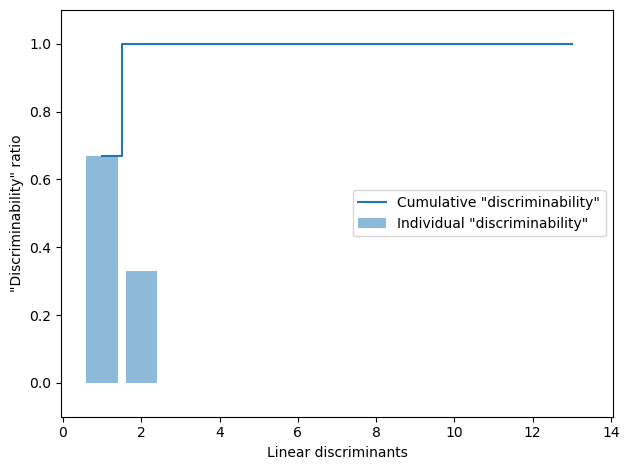

In [23]:
tot = sum(eigen_vals.real)
discr = [(i / tot) for i in sorted(eigen_vals.real, reverse=True)]
cum_discr = np.cumsum(discr) # cumsum:累積和

plt.bar(range(1, 14), discr, alpha=0.5, align='center',
        label='Individual "discriminability"')
plt.step(range(1, 14), cum_discr, where='mid',
         label='Cumulative "discriminability"')
plt.ylabel('"Discriminability" ratio')
plt.xlabel('Linear discriminants')
plt.ylim([-0.1, 1.1])
plt.legend(loc='best')
plt.tight_layout()
plt.show()

2つの線形判別だけで有益な情報を100%補足している。

# 6. 変換行列Wの作成

In [24]:
w = np.hstack((eigen_pairs[0][1][:, np.newaxis].real, 
               eigen_pairs[1][1][:, np.newaxis].real))
print('Matrix W:\n', w)

Matrix W:
 [[-0.1481 -0.4092]
 [ 0.0908 -0.1577]
 [-0.0168 -0.3537]
 [ 0.1484  0.3223]
 [-0.0163 -0.0817]
 [ 0.1913  0.0842]
 [-0.7338  0.2823]
 [-0.075  -0.0102]
 [ 0.0018  0.0907]
 [ 0.294  -0.2152]
 [-0.0328  0.2747]
 [-0.3547 -0.0124]
 [-0.3915 -0.5958]]


# 7. 変換行列Wを使ってデータ点を新しい特徴量の部分空間へ射影
$\boldsymbol{X}'=\boldsymbol{XW}$

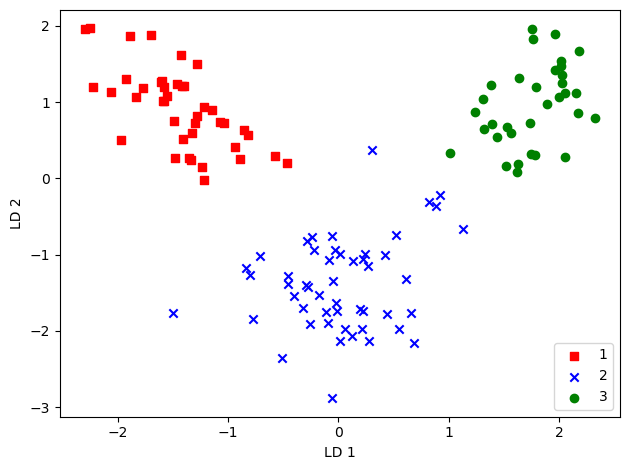

In [25]:
X_train_lda = X_train_std.dot(w) # X_train_std：X'
colors = ['r', 'b', 'g']
markers = ['s', 'x', 'o']
for l, c, m in zip(np.unique(y_train), colors, markers):
    plt.scatter(X_train_lda[y_train == l, 0],
                X_train_lda[y_train == l, 1] * (-1),
                c=c, label=l, marker=m)

plt.xlabel('LD 1')
plt.ylabel('LD 2')
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()

# scikit-learnによるLDA

In [31]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
lda = LDA(n_components=2)
X_train_lda = lda.fit_transform(X_train_std, y_train)

/var/folders/9z/vmk05b5s1mlcffm1x6y0_p8w0000gn/T/ipykernel_95152/49398212.py:23: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(x=X[y == cl, 0],


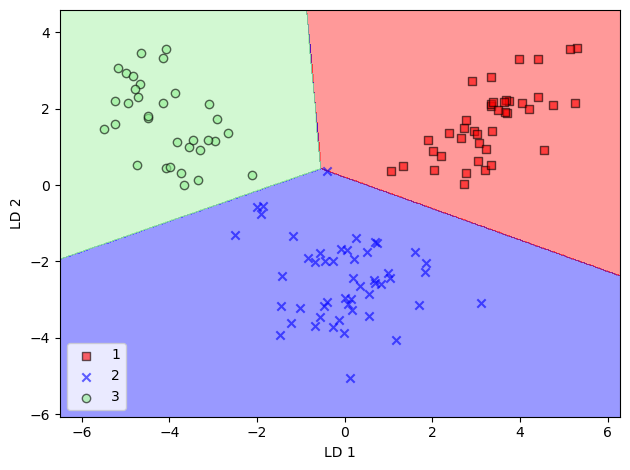

In [32]:
lr = LogisticRegression(multi_class='ovr', random_state=1, solver='lbfgs')
lr = lr.fit(X_train_lda, y_train)
plot_decision_regions(X_train_lda, y_train, classifier=lr)
plt.xlabel('LD 1')
plt.ylabel('LD 2')
plt.legend(loc='lower left')
plt.tight_layout()
plt.show()

/var/folders/9z/vmk05b5s1mlcffm1x6y0_p8w0000gn/T/ipykernel_95152/49398212.py:23: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(x=X[y == cl, 0],


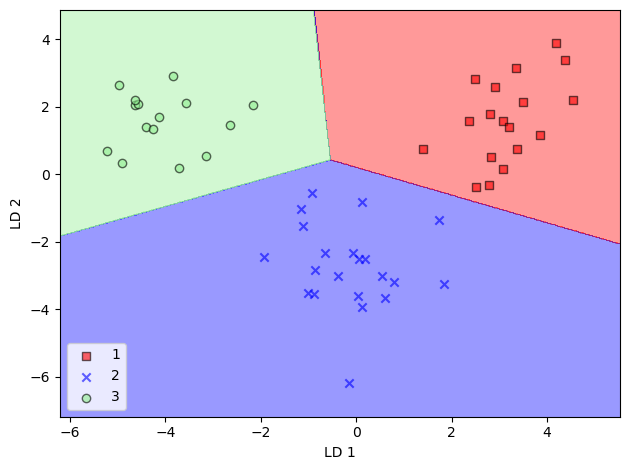

In [33]:
X_test_lda = lda.transform(X_test_std)
plot_decision_regions(X_test_lda, y_test, classifier=lr)
plt.xlabel('LD 1')
plt.ylabel('LD 2')
plt.legend(loc='lower left')
plt.tight_layout()
plt.show()

# カーネル主成分分析の実装

In [34]:
from scipy.spatial.distance import pdist, squareform
from scipy import exp
from scipy.linalg import eigh
import numpy as np

def rbf_kernel_pca(X, gamma, n_components):
    
    sq_dists = pdist(X, 'sqeuclidean') # ユークリッド距離の2乗を計算
    
    mat_sq_dists = squareform(sq_dists) # 距離を正方行列に変換
    
    K = exp(-gamma * mat_sqdists) # 対称カーネル行列を計算
    
    #カーネル行列の中心化
    N = K.shape[0]
    one_n = np.ones((N, N)) / N
    K = K - one_n.dot(K) - K.dot(one_n) + one_n.dot(K).dot(one_n)
    
    # 固有対を取得
    eigvals, eigvecs = eigh(K)
    eigvals, eigvecs = eigvals[::-1], eigvecs[:, ::-1]
    
    #上位k個の固有ベクトルを収集
    X_pc = np.column_stack((eigvecs[:, i] for i in range(n_components)))
    
    return X_pc

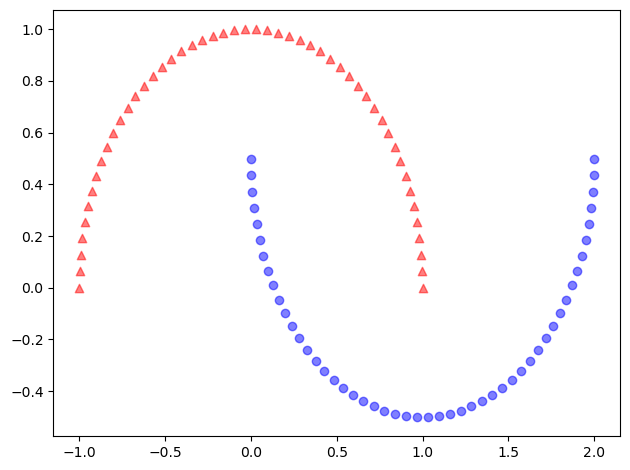

In [35]:
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons

X, y = make_moons(n_samples=100, random_state=123)

plt.scatter(X[y == 0, 0], X[y == 0, 1], color='red', marker='^', alpha=0.5)
plt.scatter(X[y == 1, 0], X[y == 1, 1], color='blue', marker='o', alpha=0.5)

plt.tight_layout()
plt.show()